<a href="https://colab.research.google.com/github/sagihaider/EEG_Deep/blob/master/Step1_mat_learn_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/sagihaider/EEG_Deep.git

Cloning into 'EEG_Deep'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 53 (delta 0), reused 3 (delta 0), pack-reused 48
Unpacking objects: 100% (53/53), done.
Checking out files: 100% (24/24), done.


In [2]:
import scipy.io as spio
import numpy as np
from importlib.machinery import SourceFileLoader

# EEGNet-specific imports
from EEG_Deep.EEGModels import EEGNet, ShallowConvNet, DeepConvNet
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
K.set_image_data_format('channels_first')

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# tools for plotting confusion matrices
from matplotlib import pyplot as plt

In [3]:
x= 1         
fName = 'EEG_Deep/Data2A/Data_A0' + str(x) + 'T.mat'  # Load Data
print(fName)
mat = spio.loadmat(fName)
X = mat['cleanRawEEGData']
y = mat['cleanClassLabels']

EEG_Deep/Data2A/Data_A01T.mat


In [4]:
print(np.shape(X))
print(np.shape(y))

(288, 22, 1875)
(288, 1)


In [5]:

# take 50/25/25 percent of the data to train/validate/test
X_train      = X[0:200,:,500:1250]
Y_train      = y[0:200]
#X_validate   = X[151:200,:,500:1250]
#Y_validate   = y[151:200]
X_test       = X[201:,:,500:1250]
Y_test       = y[201:]

print(np.shape(X_train))
print(np.shape(Y_train))
# print(np.shape(X_validate))
# print(np.shape(Y_validate))
print(np.shape(X_test))
print(np.shape(Y_test))

(200, 22, 750)
(200, 1)
(87, 22, 750)
(87, 1)


In [0]:

# convert labels to one-hot encodings.
Y_train      = np_utils.to_categorical(Y_train-1)
# Y_validate   = np_utils.to_categorical(Y_validate-1)
Y_test       = np_utils.to_categorical(Y_test-1)

In [7]:
kernels, chans, samples = 1, 22, 750

# convert data to NCHW (trials, kernels, channels, samples) format. Data 
# contains 22 channels and 500 time-points. Set the number of kernels to 1.
X_train      = X_train.reshape(X_train.shape[0], kernels, chans, samples)
# X_validate   = X_validate.reshape(X_validate.shape[0], kernels, chans, samples)
X_test       = X_test.reshape(X_test.shape[0], kernels, chans, samples)
   
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (200, 1, 22, 750)
200 train samples
87 test samples


In [8]:
# configure the EEGNet-8,2,16 model with kernel length of 32 samples (other 
# model configurations may do better, but this is a good starting point)
model = EEGNet(nb_classes = 4, Chans = 22, Samples = 750, 
             dropoutRate = 0.5, kernLength = 25, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout')

# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])

# count number of parameters in the model
numParams    = model.count_params() 

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [15]:
# the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
# the weights all to be 1
class_weights = {0:1, 1:1, 2:1, 3:1}

################################################################################
# fit the model. Due to very small sample sizes this can get
# pretty noisy run-to-run, but most runs should be comparable to xDAWN + 
# Riemannian geometry classification (below)
################################################################################
history = model.fit(X_train, Y_train, batch_size = 16, epochs = 100, 
                        verbose = 2, validation_data=(X_test, Y_test),
                        callbacks=[checkpointer], class_weight = class_weights)

Train on 200 samples, validate on 87 samples
Epoch 1/100

Epoch 00001: val_loss did not improve from 0.54943
200/200 - 1s - loss: 0.1287 - acc: 0.9800 - val_loss: 0.6557 - val_acc: 0.7471
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.54943
200/200 - 0s - loss: 0.1201 - acc: 0.9900 - val_loss: 0.6051 - val_acc: 0.7356
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.54943
200/200 - 0s - loss: 0.1036 - acc: 0.9850 - val_loss: 0.6614 - val_acc: 0.7241
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.54943
200/200 - 0s - loss: 0.1136 - acc: 0.9750 - val_loss: 0.6504 - val_acc: 0.7126
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.54943
200/200 - 0s - loss: 0.0979 - acc: 0.9850 - val_loss: 0.6513 - val_acc: 0.7471
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.54943
200/200 - 0s - loss: 0.1459 - acc: 0.9700 - val_loss: 0.7397 - val_acc: 0.7356
Epoch 7/100

Epoch 00007: val_loss did not improve from 0.54943
200/200 - 0s - loss: 0.1544 - acc

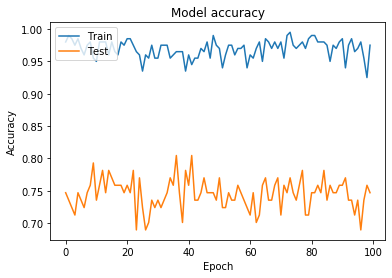

In [16]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()